<a href="https://colab.research.google.com/github/HelloShagun/useful_libs/blob/main/examples/UMAP_comparison_aqua_urban.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-616120697.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.abs(weights)[top_10_idx], y=[f'Dim {i}' for i in top_10_idx],


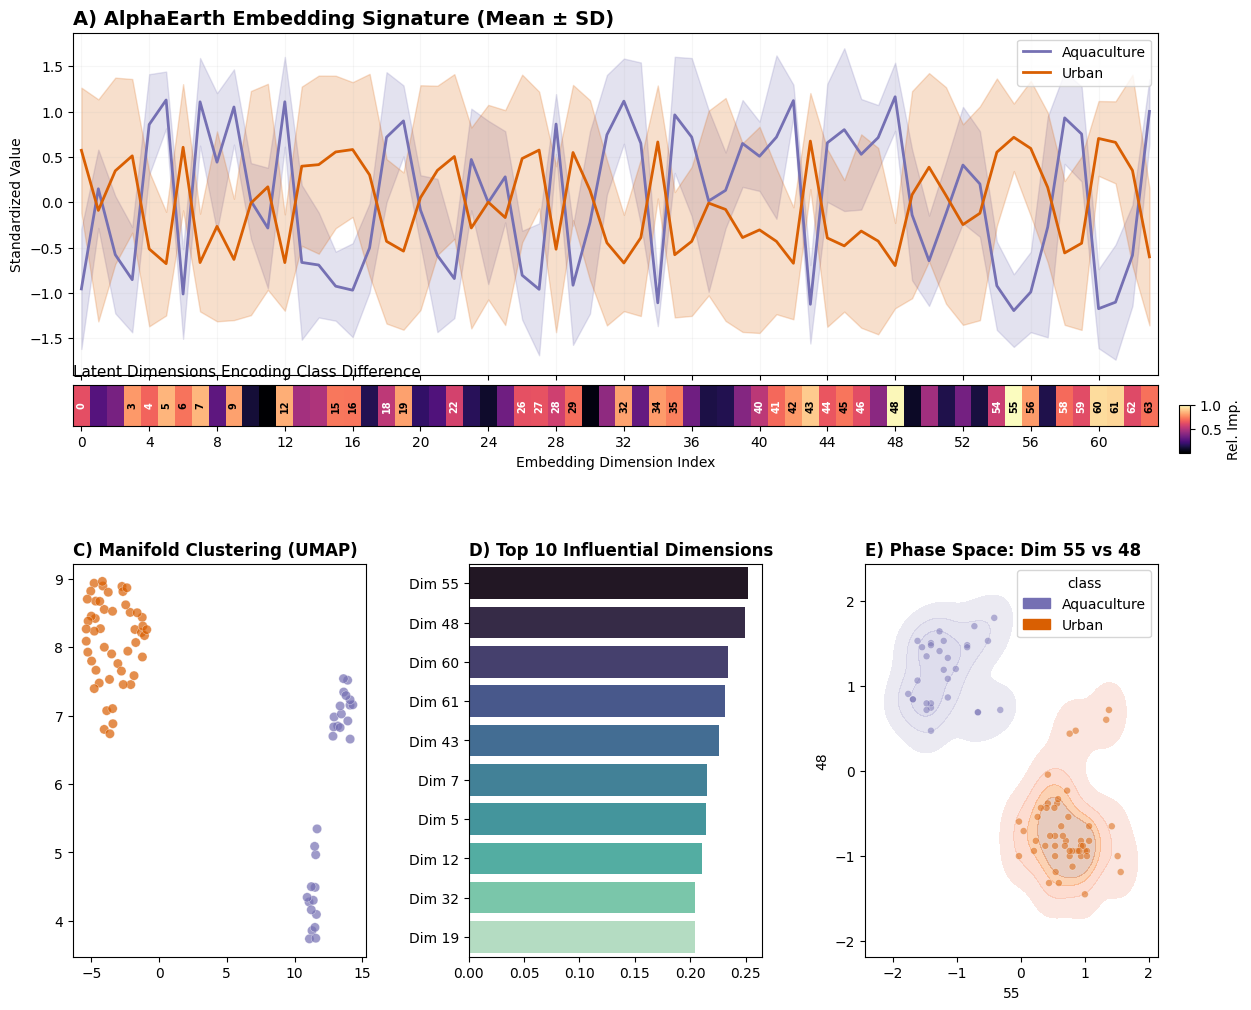

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# ==========================================
# 1. DATA LOADING / PREPARATION
# ==========================================
df = pd.read_csv('/content/AlphaEarth_Water_Analysis_Final (3).csv')

# Use your actual feature names
features = [f'A{i:02d}' for i in range(64)]

# Filter for real classes and clean the dataframe
df = df[df['class'].isin(['urban', 'aquaculture'])].reset_index(drop=True)

X = df[features].values
# Map string labels to binary for the model (Urban: 0, Aquaculture: 1)
y_bin = np.where(df['class'] == 'aquaculture', 1, 0)

# Standardize (Crucial for consistent weights and UMAP)
X_scaled = StandardScaler().fit_transform(X)

# Create DataFrame for plotting
df_feat = pd.DataFrame(X_scaled, columns=[i for i in range(64)])
df_feat['class'] = np.where(y_bin == 1, 'Aquaculture', 'Urban')

# Melt for the signature plot
df_melt = df_feat.melt(id_vars='class', var_name='dimension', value_name='value')

# ==========================================
# 2. MODEL TRAINING & FEATURE EXTRACTION
# ==========================================
clf = LogisticRegression(max_iter=2000, C=1.0)
clf.fit(X_scaled, y_bin)

weights = clf.coef_[0]
importance_norm = np.abs(weights) / np.abs(weights).max()
top_10_idx = np.argsort(np.abs(weights))[-10:][::-1]

# ==========================================
# 3. FINAL PUBLICATION FIGURE
# ==========================================
colors = ['#7570b3', '#d95f02'] # Purple for Urban, Orange for Aqua
plt.rcParams['font.family'] = 'sans-serif'

fig = plt.figure(figsize=(14, 12))
gs_main = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.35)

# --- SECTION 1: SIGNATURE & STRIP ---
gs_top = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_main[0],
                                          height_ratios=[5, 0.6], hspace=0.05)

ax0 = plt.subplot(gs_top[0])
sns.lineplot(data=df_melt, x='dimension', y='value', hue='class',
             errorbar='sd', palette=colors, ax=ax0, lw=2)
ax0.set_title('A) AlphaEarth Embedding Signature (Mean ± SD)', loc='left', fontweight='bold', fontsize=14)
ax0.set_ylabel('Standardized Value')
ax0.set_xlabel('')
ax0.set_xticks(range(0, 64, 4)) # Clearer x-axis ticks
ax0.grid(True, alpha=0.1)
ax0.legend(loc='upper right', frameon=True)

ax1 = plt.subplot(gs_top[1], sharex=ax0)
heat = importance_norm.reshape(1, -1)
im = ax1.imshow(heat, aspect='auto', cmap='magma', interpolation='nearest')

for i, val in enumerate(importance_norm):
    if val > 0.5:
        txt_color = "black" if val > 0.7 else "white"
        ax1.text(i, 0, str(i), color=txt_color, ha='center', va='center',
                 fontsize=7, fontweight='bold', rotation=90)

ax1.set_yticks([])
ax1.set_xlabel('Embedding Dimension Index')
ax1.set_title('Latent Dimensions Encoding Class Difference', fontsize=11, loc='left')

cbar_ax = fig.add_axes([0.915, 0.53, 0.008, 0.04])
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Rel. Imp.')

# --- SECTION 2: ANALYSIS TRIO ---
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_main[1], wspace=0.35)

# C) UMAP Projection
ax_umap = plt.subplot(gs_bottom[0])
u = UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X_scaled)
sns.scatterplot(x=u[:,0], y=u[:,1], hue=df_feat['class'], palette=colors,
                s=45, alpha=0.7, ax=ax_umap, edgecolor='white', linewidth=0.3)
ax_umap.set_title('C) Manifold Clustering (UMAP)', loc='left', fontweight='bold')
ax_umap.get_legend().remove()

# D) Feature Importance
ax_imp = plt.subplot(gs_bottom[1])
sns.barplot(x=np.abs(weights)[top_10_idx], y=[f'Dim {i}' for i in top_10_idx],
            palette='mako', ax=ax_imp)
ax_imp.set_title('D) Top 10 Influential Dimensions', loc='left', fontweight='bold')

# E) Phase Space
ax_phase = plt.subplot(gs_bottom[2])
dim_x, dim_y = top_10_idx[0], top_10_idx[1]
sns.kdeplot(data=df_feat, x=dim_x, y=dim_y, hue='class', fill=True,
            palette=colors, alpha=0.3, ax=ax_phase, levels=5)
sns.scatterplot(data=df_feat, x=dim_x, y=dim_y, hue='class',
                palette=colors, s=25, alpha=0.5, ax=ax_phase, legend=False)
ax_phase.set_title(f'E) Phase Space: Dim {dim_x} vs {dim_y}', loc='left', fontweight='bold')

plt.savefig('AlphaEarth_Analysis_Fixed.png', dpi=300, bbox_inches='tight')
plt.show()